lab3

варіант 1

Побудувати CNN на основі LeNet-5 для класифікації зображень на основі
датасету fashion-mnist.
Зробити налаштування моделі для досягнення необхідної точності. На базі
Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

#**Lenet-5**

In [61]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time
import os

In [63]:
(train_x, train_y), (test_x, test_y) = keras.datasets.fashion_mnist.load_data()
train_x = train_x / 255.0
test_x = test_x / 255.0

train_x = tf.expand_dims(train_x, 3)
test_x = tf.expand_dims(test_x, 3)

val_x = train_x[:5000]
val_y = train_y[:5000]

In [64]:
lenet_5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=train_x[0].shape, padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Flatten(), #Flatten
    keras.layers.Dense(120, activation='tanh'), #C5
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(10, activation='softmax') #Output layer
])


In [65]:
lenet_5_model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])


In [66]:
lenet_5_model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))

Epoch 1/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.5020 - accuracy: 0.8168 - val_loss: 0.3666 - val_accuracy: 0.8676
Epoch 2/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.3670 - accuracy: 0.8653 - val_loss: 0.3120 - val_accuracy: 0.8842
Epoch 3/5
1875/1875 [==============================] - 42s 23ms/step - loss: 0.3281 - accuracy: 0.8794 - val_loss: 0.2786 - val_accuracy: 0.8976
Epoch 4/5
1875/1875 [==============================] - 42s 23ms/step - loss: 0.3013 - accuracy: 0.8878 - val_loss: 0.2554 - val_accuracy: 0.9044
Epoch 5/5
1875/1875 [==============================] - 42s 23ms/step - loss: 0.2802 - accuracy: 0.8960 - val_loss: 0.2445 - val_accuracy: 0.9068


#**Siamese**

In [78]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [77]:
epochs = 10
batch_size = 16


In [80]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")


In [81]:

x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val


In [82]:
def make_pairs(x, y):

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):

        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]


        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)


In [89]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]


In [84]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]


In [85]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]


In [87]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


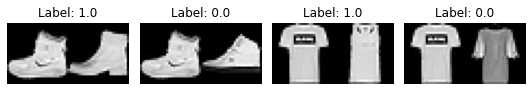

In [88]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)


In [90]:
def euclidean_distance(vects):

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [92]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           5318        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [93]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)


Epoch 1/10
3750/3750 [==============================] - 112s 29ms/step - loss: 0.2418 - accuracy: 0.5687 - val_loss: 0.1174 - val_accuracy: 0.8531
Epoch 2/10
3750/3750 [==============================] - 86s 23ms/step - loss: 0.1137 - accuracy: 0.8439 - val_loss: 0.0940 - val_accuracy: 0.8698
Epoch 3/10
3750/3750 [==============================] - 86s 23ms/step - loss: 0.1012 - accuracy: 0.8610 - val_loss: 0.0791 - val_accuracy: 0.8967
Epoch 4/10
3750/3750 [==============================] - 88s 23ms/step - loss: 0.0932 - accuracy: 0.8732 - val_loss: 0.0769 - val_accuracy: 0.8996
Epoch 5/10
3750/3750 [==============================] - 88s 23ms/step - loss: 0.0897 - accuracy: 0.8791 - val_loss: 0.0723 - val_accuracy: 0.9050
Epoch 6/10
3750/3750 [==============================] - 86s 23ms/step - loss: 0.0864 - accuracy: 0.8853 - val_loss: 0.0723 - val_accuracy: 0.9045
Epoch 7/10
3750/3750 [==============================] - 103s 28ms/step - loss: 0.0845 - accuracy: 0.8867 - val_loss: 0.0729

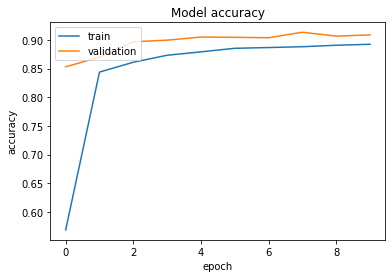

In [94]:
def plt_metric(history, metric, title, has_valid=True):
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

plt_metric(history=history.history, metric="accuracy", title="Model accuracy")



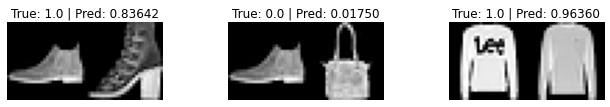

In [95]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)


#**TSNE**

In [116]:
X = np.zeros((x_train.shape[0], 784))
for i in range(x_train.shape[0]):
    X[i] = x_train[i].flatten()


X = pd.DataFrame(X)



Y = pd.DataFrame(y_train)
X = X.sample(frac=0.1, random_state=10).reset_index(drop=True)


Y = Y.sample(frac=0.1, random_state=10).reset_index(drop=True)


df = X
df['label'] = Y



In [111]:
import time

from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 10.001370429992676 seconds


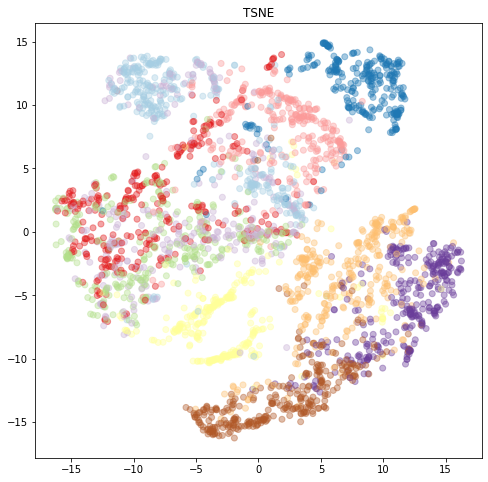

In [118]:
import matplotlib.pyplot as plt

fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )

ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=df['label'], 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()
